In [30]:
import pandas as pd
import xgboost as xbg
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [99]:
def plot_results(y_test, y_pred, model ):
    acc = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    y_pred_onehot = pd.get_dummies(y_pred)
    roc_auc = metrics.roc_auc_score(y_test, y_pred_onehot, multi_class='ovo')
    print('Model performance for {model}'.format(model=model))
    print('------------------------------------------------')
    print('Accuracy is ', acc)
    print('F1 is ', f1)
    print('ROC AUC Score is ', roc_auc)
    print('------------------------------------------------')

    
    
    metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  

## Explainable Models

### Linear Regression

In [92]:
y_pred = np.loadtxt('../../Files/models/lr_pred.csv', delimiter=',')

In [83]:
y_true = pd.read_csv('../../Files/models/y_true.csv')

In [84]:

y_true.reset_index(drop=True, inplace=True)
y_true = y_true.to_numpy()
y_true = y_true.flatten()

Model performance for Logistic Regression
------------------------------------------------
Accuracy is  0.4772888956416661
F1 is  0.2892851572138753
ROC AUC Score is  0.5812123965475927
------------------------------------------------


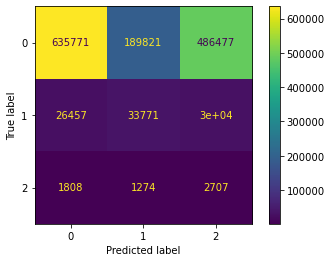

In [100]:
plot_results(y_true, y_pred, 'Logistic Regression')

### XGBoost

In [102]:
y_pred = np.fromfile('../../Files/models/xgb_test.txt', sep=' ')

In [104]:
y_pred.shape

(1408474,)

Model performance for XGBoost
------------------------------------------------
Accuracy is  0.8608841909754813
F1 is  0.53970939527811
ROC AUC Score is  0.8576378919397051
------------------------------------------------


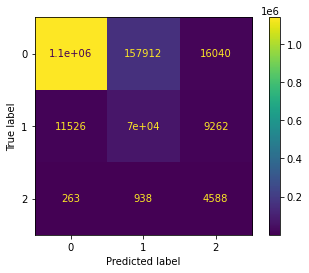

In [105]:
plot_results(y_true, y_pred, 'XGBoost')

## Neural Networks

### CNN

In [112]:
y_pred = np.loadtxt('../../Files/models/cnn_results.txt')

In [115]:
y_pred[0:10]

array([9.99912977e-01, 7.27573497e-05, 1.42607951e-05, 9.78811800e-01,
       1.94173157e-02, 1.77089276e-03, 9.99758661e-01, 1.86581878e-04,
       5.46742085e-05, 1.55724501e-06])

In [116]:
y_pred = y_pred.reshape(1408474, 3)

In [119]:
y_pred = y_pred.round()

In [121]:
y_pred = np.argmax(y_pred, axis=1)

array([0, 0, 0, 2, 0, 0, 0, 1, 0, 0])

Model performance for CNN
------------------------------------------------
Accuracy is  0.8999498748290703
F1 is  0.5749161834943711
ROC AUC Score is  0.8847233525388848
------------------------------------------------


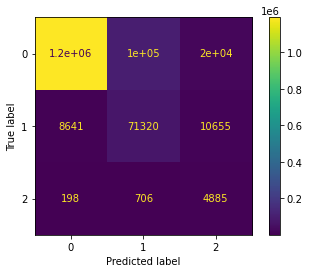

In [123]:
plot_results(y_true, y_pred, 'CNN')

### Pre-trained BERT